### Scheduling simulation visualization

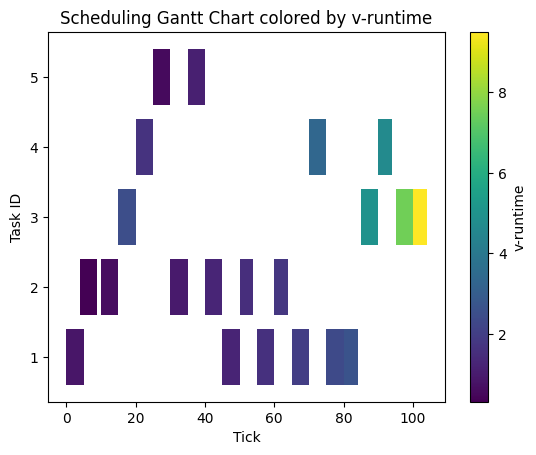

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

def load_data(file_path: str) -> pd.DataFrame:
    return pd.read_csv(file_path)
    
df = load_data('scheduling.csv')

# Compute run intervals: for each Dispatch, find next Preempt/Finish for same task
dispatches = df[df['event'] == 'Dispatch']
intervals = []
for idx, start in dispatches.iterrows():
    tid = start['task_id']
    next_evt = df[(df['task_id'] == tid) & 
                  (df.index > idx) & 
                  (df['event'].isin(['Preempt', 'Finish']))
                ]
    if next_evt.empty:
        continue

    # Get the first next event that is either Preempt or Finish
    end_evt = next_evt.iloc[0]
    start_tick = start['tick']
    duration = end_evt['ran_ticks']
    vr = end_evt['vruntime']
    intervals.append((tid, start_tick, duration, vr))

# Normalize v-runtime for colors
vr_values = [iv[3] for iv in intervals]
norm = mpl.colors.Normalize(vmin=min(vr_values), vmax=max(vr_values))
cmap = plt.cm.viridis

# Plot Gantt chart
fig, ax = plt.subplots()
for tid, start, duration, vr in intervals:
    ax.broken_barh([(start, duration)], (tid - 0.4, 0.8),
                   facecolors=cmap(norm(vr)))

ax.set_xlabel('Tick')
ax.set_ylabel('Task ID')
ax.set_yticks(sorted({iv[0] for iv in intervals}))
ax.set_title('Scheduling Gantt Chart colored by v-runtime')

# Add colorbar
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array(vr_values)
fig.colorbar(sm, ax=ax, label='v-runtime')

plt.show()
